# Business understanding

The challenging thing of this project is that you have to come up with your own business questions. I am curious about the differences of programming languages. This dataset has been analysed often and a lot of the serious questions were already asked. So the decision is to take a less serious aproach in giving advice on what programming language to learn. This is a good use case where analysing the difference of languages is required.


# Data understanding
To get an understanding which questions can be answered we first need to have a look at the available questions and answers:

In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from IPython import display
%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
df.head()
#schema = pd.read_csv('./survey_results_schema.csv')
#schema.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 Looking at the survey the following questions are viable:
 What language to learn when
- it is all about money? Currently financial freedom and early retirement are hot topics. Interesting questions to answer this are *Salary*, *ExpectedSalary* and *Overpaid*
- you want to care for your family, your private hobby and still be accepted? Interesting questions to answers this are *ProgramHobby*, *JobSecurity* and *CompanySize*
- you want to be special and stand out? This can be answered by looking at how different the answers of all questions are grouped by programming language
Since we want to make conclusins about future jobs we only will consider developers in the study.

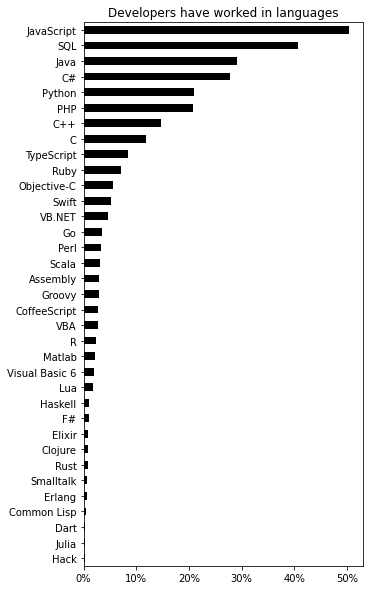

In [265]:
def clean_and_plot_column_answers(df,column, title='Values in ', plot=True):
    '''
    INPUT 
        df - a dataframe holding the column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    column_df = df[column].str.split("; ").explode().value_counts(ascending = True)
    props_df = column_df/df.shape[0]
    if plot:
        ax = props_df.plot(kind='barh', legend=None, figsize=(5,10),color="black");
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.title(title);
        plt.show()
    return props_df

df_copy2 = df[df["Professional"].isin(["Professional developer", "Used to be a professional developer"])].copy()
props_df = clean_and_plot_column_answers(df_copy2, "HaveWorkedLanguage", "Developers have worked in languages")

We can see that summing up the values by far exceeds 100%. This is a result of treating every survey answer for each language individualy. JavaScript is by far the most popular language. The list of languages is quite long. In oder to get rid of outliners the following investigation will focuse on the mainstream languages. This is done by considering only languages that are used by more than 3% of developers. To be able to make an conclusions about languages the properties of a single respondent are considered for all languages he worked in.

# Data perparation
In oder to get rid of outliners the following investigation will only consider languages that are used by more than 3% of developers. To be able to make an conclusions about languages the properties of a single respondent are considered for all languages he worked in. We have to drop all survey response that have NA/null in *HaveWorkedLanguage*. The reason is that we only care about survey responses that answered this question. This intended because we want to answer questions based on developers who actually know a language. Investigating what developers that do not answer this question are doing is interesting as well. However it does not answer any of our questions. For continuous values we consider the mean of the answers. For Categorial variables we normalize the distribution of answers.

In [266]:
language_vals = df["HaveWorkedLanguage"].str.split("; ").explode().dropna().unique()
# only get developers
df_copy = df[df["Professional"].isin(["Professional developer", "Used to be a professional developer"])].copy()
props_df = df_copy["HaveWorkedLanguage"].str.split("; ").explode().value_counts(ascending = True)/df.shape[0]
df_copy["HaveWorkedLanguage"] = df_copy["HaveWorkedLanguage"].str.split("; ")
by_language_df = pd.DataFrame(columns = df.columns)
for language in language_vals:
    # only get relevant languages
    if props_df[language] > 0.02:
        language_df = df_copy[df_copy["HaveWorkedLanguage"].astype(str).str.contains(str(language), na=False, regex=False)]# for row containing language sum, 
        language_vals = {}
        language_vals["Language"] = language
        for column in language_df:
            is_continuous = column in df.select_dtypes(include='number').columns
            if is_continuous:
                language_vals[column] = language_df[column].mean()
            else:
                language_vals[column]= language_df[column].str.split("; ").explode().value_counts(normalize=True)
        by_language_df = by_language_df.append(language_vals,ignore_index=True)

by_language_df.set_index("Language", inplace=True)
# columns to drop because they do not make sense when analysing developers of specific languages
by_language_df.drop(columns=["HaveWorkedLanguage", "Respondent","NonDeveloperType"], inplace=True);

In [267]:
# seems like the dataset does not contain any expected salary of developers
df[df["Professional"].isin(["Professional developer", "Used to be a professional developer"])]["ExpectedSalary"].dropna().shape

(0,)

In [268]:
# since there is no data we also will get rid of the column
by_language_df.drop(columns=["ExpectedSalary"], inplace=True);

# Further data preparation and evaluation

Let´s answer the questions:


## The money question
What when it is all about money? Interesting questions to answer this are *Salary*, *ExpectedSalary* and *Overpaid*. 
In the previous step we discovered that *ExpectedSalary* does not contain any useful data. So we will discard that idea. We already calculated the mean of continuous variables. So we can directly have a look at *Salary*:

c:\Users\zip9fe\.conda\envs\dataScience\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
c:\Users\zip9fe\.conda\envs\dataScience\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


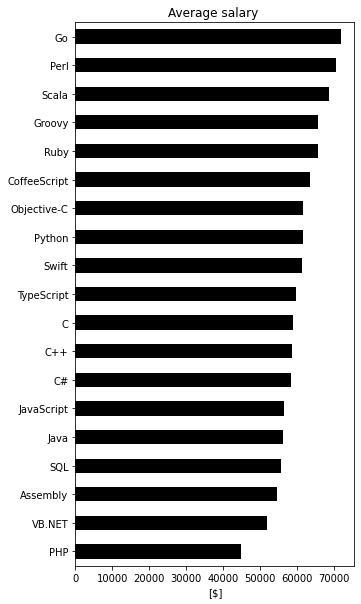

In [269]:
def remove_yaxis_label():
    ax1 = plt.axes()
    y_axis = ax1.axes.get_yaxis()
    y_axis.set_label_text('foo')
    y_label = y_axis.get_label()
    y_label.set_visible(False)
    
def set_xaxis_label(text):
    ax1 = plt.axes()
    x_axis = ax1.axes.get_xaxis()
    x_axis.set_label_text(text)

by_language_df["Salary"].sort_values().plot(kind='barh', legend=None, figsize=(5,10), color = "black")
plt.title("Average salary ");
remove_yaxis_label()
set_xaxis_label("[$]")

For *Overpaid* we need to handle the fact that it is a categorial variable. In order to be able to compare the data we take the simplest aproach and map the categories to values. Justification why this is okay is given here: https://stats.stackexchange.com/questions/539/does-it-ever-make-sense-to-treat-categorical-data-as-continuous. With this it is possible to calculate a median value which then can be compared for each language.

c:\Users\zip9fe\.conda\envs\dataScience\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


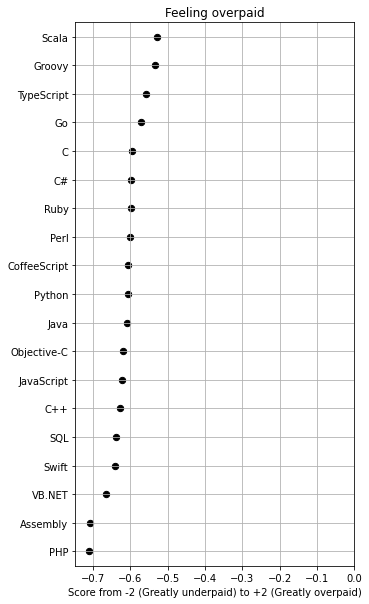

In [282]:
def convertToContinuous(df, column_name, cat_to_cont_map):
    '''
    INPUT 
        df - a dataframe holding the column
        column_name - string the column to convert. Has to contain normalized categorical data
        cat_to_cont_map - dict holding the data mapping. np.nan categories get discarded.
        
    OUTPUT
        df_cont_ext - a dataframe with the column as additional continuous data
    '''
    df_cont_ext = df.copy()
    scores = []
    # this only works for column values already normalized probabilites
    for language, language_vals in df_cont_ext[column_name].items():
        score = 0
        prob_nan = 0
        for cat in cat_to_cont_map:
            if np.isnan(cat_to_cont_map[cat]):
                prob_nan = language_vals[cat]
            else:
                score += language_vals[cat]*cat_to_cont_map[cat]
        score = score/(1-prob_nan)
        scores.append(score)
    df_cont_ext["cont_"+ column_name] = scores
    return df_cont_ext

def plot_cat_column_as_continuous(df, column_name, cat_to_cont_map, values_ascending = True, subplot_ax = None):
    '''
    INPUT 
        df - a dataframe holding the column
        column_name - string the column to convert. Has to contain normalized categorical data
        cat_to_cont_map - dict holding the data mapping. np.nan categories get discarded.
        subplot_ax - subplot position
    '''
    by_language_df_overpaid = convertToContinuous(by_language_df, column_name, cat_to_cont_map)
    cont_column_name = "cont_" + column_name
    ax = by_language_df_overpaid[cont_column_name].sort_values(ascending = values_ascending).plot(kind='barh', legend=None, figsize=(5,10), color = "#00000000", grid = "on", ax = subplot_ax )
    remove_yaxis_label()
    column_to_plot = by_language_df_overpaid[cont_column_name].sort_values(ascending = values_ascending)
    plt.scatter(column_to_plot.values, y=np.arange(column_to_plot.shape[0]), color='black', s=40)
    return ax

overpaid_to_cont = {
    "Greatly underpaid" : -2,
    "Somewhat underpaid": -1,
    "Neither underpaid nor overpaid" : 0,
    "Somewhat overpaid" : 1,
    "Greatly overpaid" : 2
}

ax =plot_cat_column_as_continuous(by_language_df, "Overpaid", overpaid_to_cont)
plt.title("Feeling overpaid");
ax.set_xlabel("Score from -2 (Greatly underpaid) to +2 (Greatly overpaid)");

To improve visuals we plot both plots next to eachother

## The family person question
You want to care for your family, your private hobby and still be accepted? Interesting questions to answers this are *ProgramHobby*, *JobSecurity* and *CompanySize*.
The *ProgramHobby* and *JobSecurity* questions are categorial. So we take the mapping aproach once again. The possible answers make mapping the answers to values more questionable. The output still should get us at least an idea about the differences:

c:\Users\zip9fe\.conda\envs\dataScience\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Text(0.5, 0, 'Score from 0 (No) to 3 (Program hobby & contribution to OSS)')

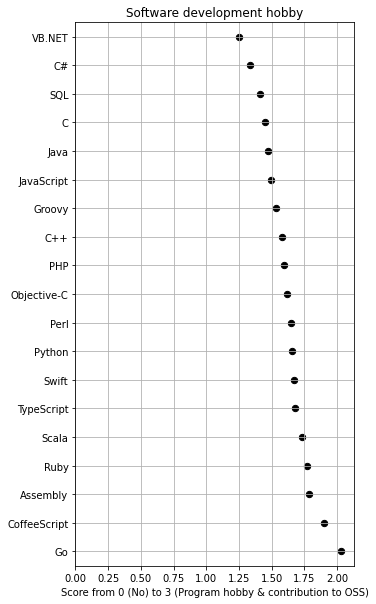

In [283]:
hobby_to_cont = {
    "Yes, both" : 3,
    "Yes, I contribute to open source projects": 2,
    "Yes, I program as a hobby": 1,
    "No" : 0
}

ax =plot_cat_column_as_continuous(by_language_df, "ProgramHobby", hobby_to_cont, values_ascending = False)
plt.title("Software development hobby");
ax.set_xlabel("Score from 0 (No) to 3 (Program hobby & contribution to OSS)");


c:\Users\zip9fe\.conda\envs\dataScience\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


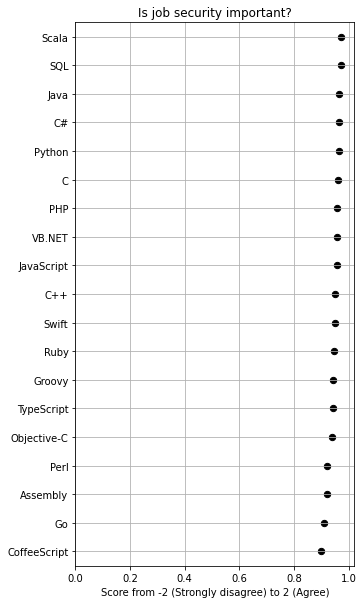

In [284]:
security_to_cont = {
    "Strongly disagree" : -2,
    "Disagree": -1,
    "Somewhat agree": 1,
    "Agree" : 2
}

ax =plot_cat_column_as_continuous(by_language_df, "JobSecurity", security_to_cont)
plt.title("Is job security important?");
ax.set_xlabel("Score from -2 (Strongly disagree) to 2 (Agree)");

Answers to jobsecurity differ only very slightly based on language. This is not an interesting result to show ... 
The question *CompanySize* gives ranges. It should given the big dataset converting it to a continuous variable should again at least give an idea of the differences:

c:\Users\zip9fe\.conda\envs\dataScience\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


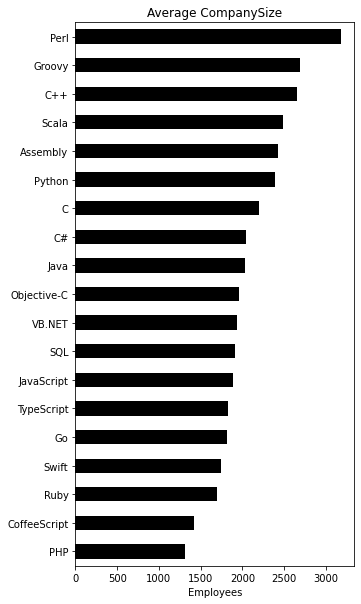

In [306]:
CompanySize_to_cont = {
    "Fewer than 10 employees" : 5,
    "10 to 19 employees": 15,
    "100 to 499 employees": 300,
    "500 to 999 employees" : 750,
    "1,000 to 4,999 employees": 2500,
    "5,000 to 9,999 employees": 7500,
    "10,000 or more employees": 10000,
    "I don't know": np.nan,
    "I prefer not to answer": np.nan
}

by_language_df_CompanySize = convertToContinuous(by_language_df, "CompanySize", CompanySize_to_cont)
ax = by_language_df_CompanySize["cont_CompanySize"].sort_values(ascending = True).plot(kind='barh', legend=None, figsize=(5,10), color = "black")

plt.title("Average CompanySize");
ax.set_xlabel("Employees");
remove_yaxis_label()

## The special language question
You want to be special? Let´s figure out the differences for all questions. To get meaningful results we only consider questions with more than 5% answer rate. For all questions we compare the answers of one language with the overall average answer. Since we want to compare continuous and categorical variables the idea is to use the chi square scoro for categorical variables. For continuous variable we use the difference from the mean in percent: 

In [286]:
diff_language_df = by_language_df.copy()
languages = by_language_df.index.tolist()
# for categorial variables the chi squared score is needed https://www3.nd.edu/~rwilliam/stats1/x51.pdf
# this only can be calculated when knowing the previous/average istribution already
for column in by_language_df:
        is_continuous = column in by_language_df.select_dtypes(include='number').columns
        if is_continuous:
            mean = by_language_df[column].mean()
            d_mean = np.empty(len(languages))
            vals = by_language_df[column].tolist()
            for i in range(len(vals)):
                d_mean[i] = abs(mean - vals[i])/mean
                diff_language_df.loc[[languages[i]],column] = d_mean[i]
        else: 
            answers = df[column].str.split("; ").explode().unique()
            answer_df = pd.Series(np.zeros((len(answers))), index = answers)
            for language_dist in by_language_df[column]:
                answer_df = answer_df.add(language_dist, fill_value=0)
            avg_answers = answer_df/by_language_df.shape[0]
            i = 0
            for language_dist in by_language_df[column]:
                diff_language_df.loc[[languages[i]],column] =(np.square(avg_answers.sub(language_dist,fill_value=0))/avg_answers).sum()
                i = i+1

Now we can plot. The survey contains a lot of questions. In order to generate a meaningful plot we only consider the questions with the highest difference.

[Text(114.0, 0.5, '')]

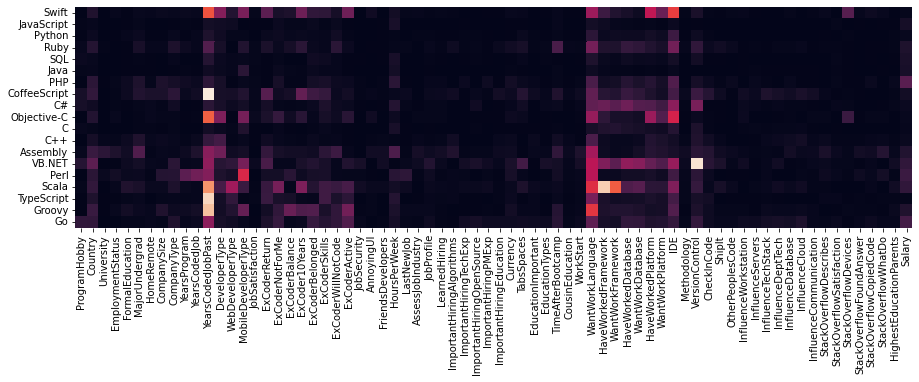

In [295]:
most_diff_language_df = diff_language_df.loc[:,diff_language_df.sum()>0.0]
fig, ax = plt.subplots(figsize=(15,25))
ax = sns.heatmap(most_diff_language_df.fillna(-1), square = True, ax=ax, cbar= False)
ax.set(ylabel=None)

Now let´s only consider the interesting things. We exclude all questions with a small difference maximum. Additionally we remove the ExCoder questions. The reason for this is that these questions are not that interesting for answering our new questions and their meaning is not easily guessed from the question title.

[Text(69.0, 0.5, '')]

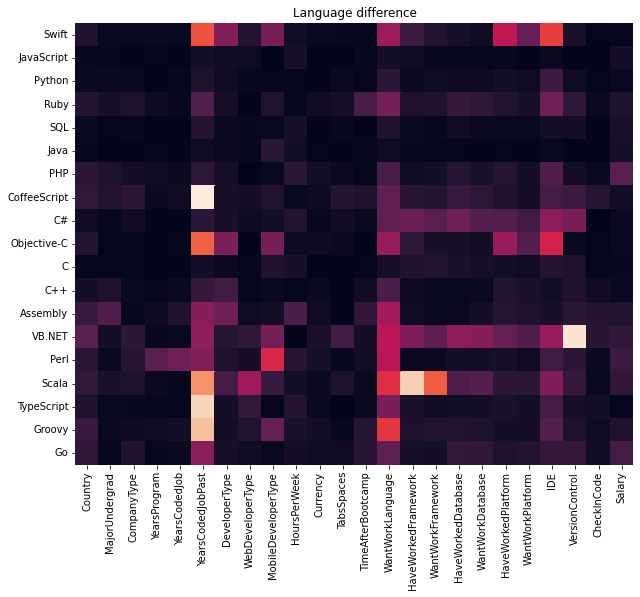

In [314]:
diff_language_df_clean =diff_language_df[diff_language_df.columns.drop(list(df.filter(regex="ExCoder*")))]
most_diff_language_df = diff_language_df_clean.loc[:,diff_language_df.sum()>0.6]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(most_diff_language_df.fillna(-1), square = True, ax=ax, cbar= False)
plt.title("Language difference");
ax.set(ylabel=None)

Now we can have a look at a few interesting fields

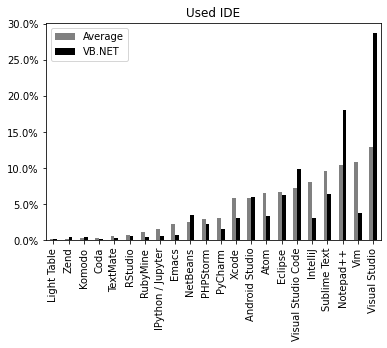

In [393]:
def plot_diff_to_avg(language,column,df):
    '''
    INPUT 
        df - a dataframe holding the column
        column_name - string the column to convert. Has to contain normalized categorical data
        cat_to_cont_map - dict holding the data mapping. np.nan categories get discarded.
        subplot_ax - subplot position
    '''
    answers = df[column].str.split("; ").explode().unique()
    answer_df = pd.Series(np.zeros((len(answers))), index = answers)
    for language_dist in df[column]:
        answer_df = answer_df.add(language_dist, fill_value=0)
    avg_answers = (answer_df/df.shape[0]).sort_values()
    diff_df = pd.concat([avg_answers,df.loc[language][column]], axis=1)
    ax = diff_df.dropna().plot(kind = "bar",color = ["grey", "black"])
    ax.legend(["Average",language]);
    return ax

ax = plot_diff_to_avg("VB.NET", "IDE",by_language_df)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title("Used IDE");

Text(0.5, 1.0, 'Used IDE')

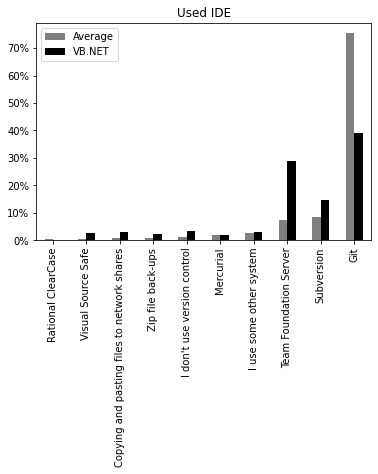

In [396]:
ax = plot_diff_to_avg("VB.NET", "VersionControl",by_language_df)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title("Version control");